In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import re #regular expression libary
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

## 1. Import data

In [8]:
papers = pd.read_csv("papers.csv")
# Print out the first rows of papers
print(papers.head())

     id  year                                              title event_type  \
0     1  1987  Self-Organization of Associative Database and ...        NaN   
1    10  1987  A Mean Field Theory of Layer IV of Visual Cort...        NaN   
2   100  1988  Storing Covariance by the Associative Long-Ter...        NaN   
3  1000  1994  Bayesian Query Construction for Neural Network...        NaN   
4  1001  1994  Neural Network Ensembles, Cross Validation, an...        NaN   

                                            pdf_name          abstract  \
0  1-self-organization-of-associative-database-an...  Abstract Missing   
1  10-a-mean-field-theory-of-layer-iv-of-visual-c...  Abstract Missing   
2  100-storing-covariance-by-the-associative-long...  Abstract Missing   
3  1000-bayesian-query-construction-for-neural-ne...  Abstract Missing   
4  1001-neural-network-ensembles-cross-validation...  Abstract Missing   

                                          paper_text  
0  767\n\nSELF-ORGANIZATI

## 2. Preparing the data for analysis
<p>For the analysis of the papers, we are only interested in the text data associated with the paper as well as the year the paper was published in.</p>


In [9]:
# Remove the columns
df = pd.DataFrame(papers)
df = df[['year','paper_text']]

# Print out the first rows of papers
print(df.head())

   year                                         paper_text
0  1987  767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1  1987  683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2  1988  394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3  1994  Bayesian Query Construction for Neural\nNetwor...
4  1994  Neural Network Ensembles, Cross\nValidation, a...


## 3. Plotting how machine learning has evolved over time
<p>In order to understand how the machine learning field has recently exploded in popularity, we will begin by visualizing the number of publications per year. </p>

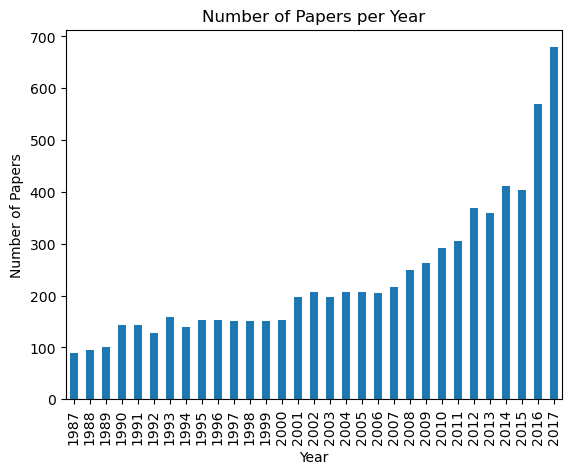

In [10]:
# Group the papers by year
groups = df.groupby('year')

# Determine the size of each group
counts = groups.size()

# Visualise the counts as a bar plot
counts.plot(kind='bar')
plt.title('Number of Papers per Year')
plt.xlabel('Year')
plt.ylabel('Number of Papers')
plt.show()

## 4. Preprocessing the text data
<p>First, perform some simple preprocessing on the titles - remove punctuation and lowercasing.</p>

In [11]:
# Remove punctuation
papers['title_processed'] = papers['title'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase
papers['title_processed'] = papers['title_processed'].map(lambda x: x.lower())

# Print the processed titles of the first rows 
print(papers['title_processed'].head())

0    self-organization of associative database and ...
1    a mean field theory of layer iv of visual cort...
2    storing covariance by the associative long-ter...
3    bayesian query construction for neural network...
4    neural network ensembles cross validation and ...
Name: title_processed, dtype: object


## 5.  A word cloud to visualize the preprocessed text data
<p>We can make a word cloud of the titles of the research papers. This will give us a visual representation of the most common words, also help us to verify if preprocessing is done correctly.</p>
<p>Python has a massive number of open libraries! Instead of trying to develop a method to create word clouds ourselves, we'll use Andreas Mueller's <a href="http://amueller.github.io/word_cloud/">wordcloud library</a>.</p>

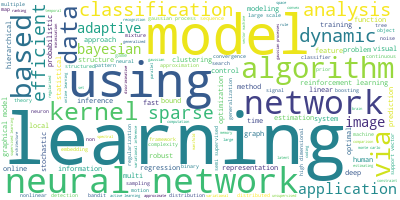

In [12]:
# Join the different processed titles together.
long_string = ' '.join(papers['title_processed'])
wordcloud = WordCloud(background_color="white", max_words=5000)

# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

## 6. LDA (Latent Dirichlet Allocation) for text analysis
<p>LDA is able to perform topic detection on large document sets, determining what the main 'topics' (collection of words that tend to co-occur often) are in a large unlabeled set of texts. The hypothesis is that LDA might be able to clarify what the different topics in the research titles are. These topics can then be used as a starting point for further analysis.</p>
<p>However, LDA does not work directly on text. Therefore, first, we will convert the documents into a simple vector representation, where each vector element represents the frequency of a particular word in a document. Essentially, we are converting a collection of titles into a series of vectors, each with a length matching the size of the overall vocabulary. For example, <em>'Analyzing machine learning trends with neural networks.'</em> would be transformed into <code>[1, 0, 1, ..., 1, 0]</code>.</p>
Finally, we will analyze and plot the ten most frequently occurring words based on these document vectors. As a validation step, we expect these words to also appear in the generated word cloud.


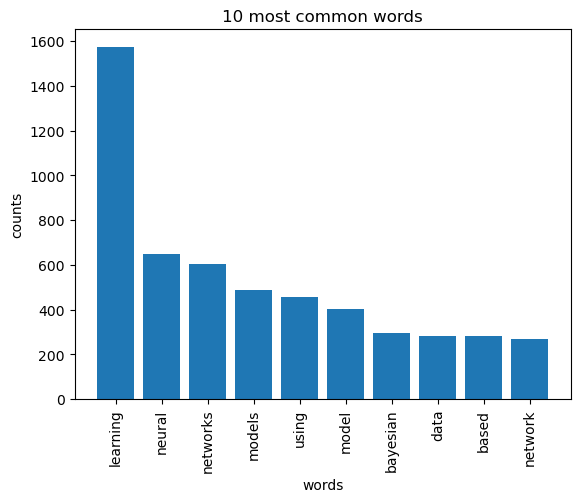

In [13]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names_out()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 

    plt.bar(x_pos, counts,align='center')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.title('10 most common words')
    plt.show()

# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed titles
count_data =  count_vectorizer.fit_transform(papers['title_processed'])
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

## 7. Analysing trends with LDA


In [15]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below (use int values below 15)
number_topics = 10
number_words = 10

# Create and fit the LDA model
lda = LDA(n_components=number_topics)
lda.fit(count_data)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
learning analysis feature data multi multiple unsupervised sparse structure structured

Topic #1:
learning optimization markov decision optimal convex algorithms processes reinforcement stochastic

Topic #2:
models neural graph networks network carlo monte random propagation time

Topic #3:
inference learning approximation function approximate policy value based linear map

Topic #4:
using based neural network model optimal recognition memory analog classifiers

Topic #5:
matrix estimation vector learning using support rank kernel linear regularization

Topic #6:
model learning models latent data using probabilistic approach bayesian neural

Topic #7:
learning networks neural deep large scale based training reinforcement using

Topic #8:
networks learning neural gaussian bayesian process multi models non sparse

Topic #9:
gradient classification recognition descent method speech neural methods estimation models
